# Stroke prediction competition: SDS - Business&Decision Hackathon (2023)

This script shows the work done for the SDS - Business & Decision Hackathon (2023). The obejective of the hackathon was to develop a model to predict whether or not a patient is likely to have a stroke or not. For this purpose, we ended up using the XGBoost library, with cross validation and fine-tuning. A special focus was given to the fact that the the dataset is quite imbalanced, with many more instances of 'no stroke'. To deals with this, we used the 'scale_pos_weight' parameter of XGBoost. 

The chosen model was used to buiild an app that gives you the porbability of having an stroke according to your ersonal data. In certain forms of stroke it is vitally important to be very quick to react to it, so we consider that raising awareness and helping people understand the likelihood of having a stroke can save lifes.

The model was develop over a time spam of 24 hours, and it could be further refined, but it is a good first step to understand the classification of unbalanced data and the trade-off between accuracy and recall. The result generalized well, and the model ended up second in the competition. Some minor changes have been done in this script since the date of the competition to make it more clear.

## Intro

First we import the relevant packages and charge the data. We also do a simple exploration to check that the data was charge properly, and wheter we have missing values or not. 

The competition included two datasets: traning and testing. The testing dataset didn't include the variable 'Stroke', and it had to be used to generate the predictions for the submission. Therefore, here we focus on the first dataset.

In [1]:
import numpy as np

import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score,confusion_matrix,precision_score, recall_score,accuracy_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV

In [2]:
df_training = pd.read_csv('C:/Users/santi/OneDrive/Escritorio/SD Hackathon/training-stroke.csv')

In [3]:
df_training.columns

Index(['id', 'Age', 'Gender', 'Married', 'Employment_Type', 'Urban_Rural',
       'Smoker', 'BodyMassIndex', 'Hypertension', 'Had_Heart_Disease',
       'Mean_Glucose_Level', 'Stroke'],
      dtype='object')

In [4]:
df_training.head()

,id,Age,Gender,Married,Employment_Type,Urban_Rural,Smoker,BodyMassIndex,Hypertension,Had_Heart_Disease,Mean_Glucose_Level,Stroke
0,4ff7cf09f18c920302462b55847e16b2,76.0,Female,Yes,Private,Urban,Unknown,38.7,0,0,198.02,0
1,084d356e9bcffa5c86b4043a63457b86,4.0,Female,No,children,Rural,Unknown,17.9,0,0,109.81,0
2,ab1ac9816b0217332806ca2b5b6ea05c,44.0,Female,Yes,Govt_job,Rural,never smoked,34.1,0,0,81.13,0
3,34397a04ace45dd67fc43e09871ff3a5,12.0,Male,No,children,Urban,Unknown,16.1,0,0,67.06,0
4,1e673deaeba32496ff359b7849008145,64.0,Female,Yes,Self-employed,Urban,never smoked,24.4,1,0,93.78,0


In [5]:
df_training.isnull().sum()

id                      0
Age                     0
Gender                  0
Married                 0
Employment_Type         0
Urban_Rural             0
Smoker                  0
BodyMassIndex         160
Hypertension            0
Had_Heart_Disease       0
Mean_Glucose_Level      0
Stroke                  0
dtype: int64

We can see that that the __data is quite clean__, with only one variable having __missing values__: BodyMassIndex. To solve this problem, we will use a simple imputation. To do so, first we plot the histogram of the variable. We can see that the variable seems to be normaly distributed, but it is slightly skewed to the right, with a couple of extreme outliers. Taking into account this, we used the median for the imputation. (More complex solutions, like using a regression to imputatae the values were studied. If this tools are used, a special attention should be given to avoiding data leakeage.)

More exploration of the data was undertaken to assure that it was clean, but it won't be showed here. After exploring the data, the only other action that seemed neccesary was deleting the only instace with the value 'other' for the variable 'gender'. As there were only one instance with this value it didn't bring any value to our analysis, and it could create trouble when aplying the model to the testing dataset.

<Axes: xlabel='BodyMassIndex', ylabel='Count'>

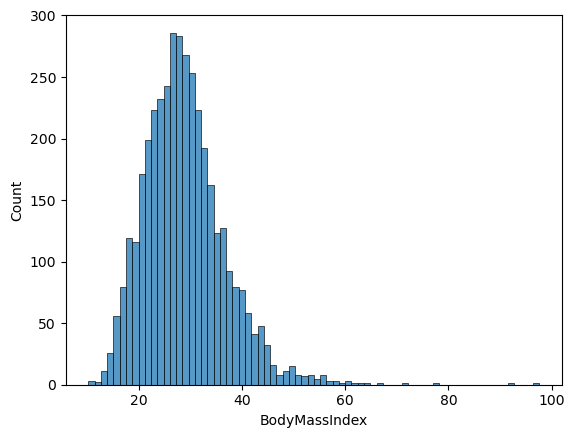

In [6]:
sns.histplot(data=df_training, x='BodyMassIndex')

In [7]:
df_training['Gender'].value_counts()

Female    2396
Male      1691
Other        1
Name: Gender, dtype: int64

In [8]:
df_training = df_training.drop('id', axis=1)

numerical = ['Age','BodyMassIndex','Mean_Glucose_Level']
categorical_vars = ['Gender', 'Married', 'Employment_Type', 'Urban_Rural',
       'Smoker', 'Hypertension', 'Had_Heart_Disease']

imp = SimpleImputer(strategy='median')
df_training['BodyMassIndex'] = imp.fit_transform(df_training['BodyMassIndex'].values.reshape(-1, 1) )
df_training = df_training[df_training.Gender != 'Other']

y= df_training['Stroke']
X = df_training.drop('Stroke', axis=1)

In [9]:
print(df_training.isnull().sum())

Age                   0
Gender                0
Married               0
Employment_Type       0
Urban_Rural           0
Smoker                0
BodyMassIndex         0
Hypertension          0
Had_Heart_Disease     0
Mean_Glucose_Level    0
Stroke                0
dtype: int64


After cleaning the data (and to assure that we don't have to clean it further) it is the time to do some __EDA__. On this script the focus is on the predictive model, so we will not show a deep EDA. Still, we will plot some graphs from which we can obtain the following __key insights__:
- The dataset is extremely unbalanced.
- The numerical variable with the higher correlation with 'stroke' is 'age'. This variable is also highly correlated with other explanatory variables.
- The distribution of strokes across ages is extremely relevant, as there are virtually no strokes before the age of 30 years.
- There seems to be some complex and nonlinear correlation. For instance, not only the percentage of strokes of males is higher, but also the distribution of Strokes across ages is different according to age. Our model should not ignore this multivariate relations.

This complexity is what push us to use a model such as XGBoost, instead of other approaches like Logit.

<Axes: xlabel='Stroke', ylabel='count'>

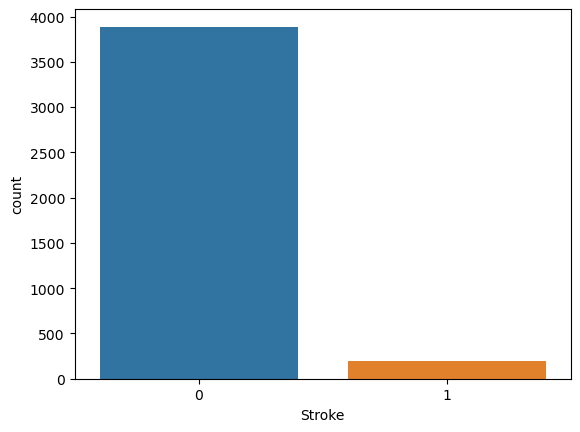

In [10]:
sns.countplot(x=y)

<Axes: >

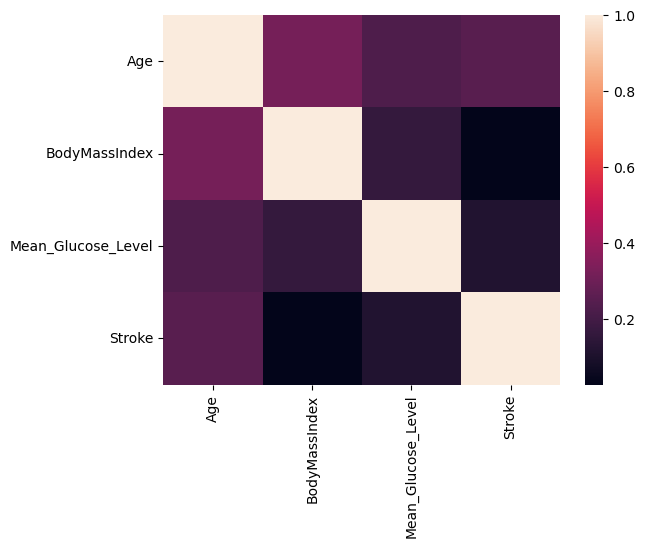

In [11]:
sns.heatmap(df_training[['Age','BodyMassIndex','Mean_Glucose_Level','Stroke']].corr())

In [12]:
print(df_training.groupby('Gender')['Stroke'].value_counts())
femstrokes = 112/(112+2284)
malestrokes = 87/(87+1604)

print('% of females with Stroke: ' + str(femstrokes))
print('% of males with Stroke: ' + str(malestrokes))

Gender  Stroke
Female  0         2284
        1          112
Male    0         1604
        1           87
Name: Stroke, dtype: int64
% of females with Stroke: 0.04674457429048414
% of males with Stroke: 0.0514488468361916


<Axes: xlabel='Age', ylabel='Density'>

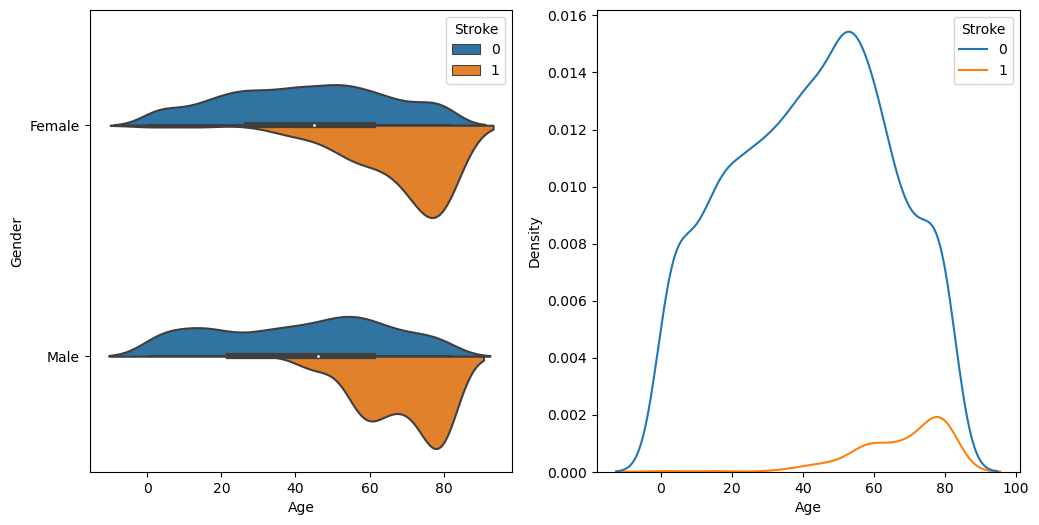

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(ax=axes[0], data=df_training, x="Age", y="Gender", hue="Stroke", split=True)
sns.kdeplot(ax=axes[1], data=df_training, x="Age", hue="Stroke")

After the EDA, we apply __One Hot Econding__ to the categorical variables, so they can be used by our model.

In [14]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False, drop = "first")

# apply the one hot encoder logic 
encoder_vars_array = one_hot_encoder.fit_transform(X[categorical_vars])

# create object for the feature names using the categorical variables
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create a dataframe to hold the one hot encoded variables
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)

# concatenate the new dataframe back to the original input variables dataframe
X_new = pd.concat([X.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)

# drop the original input 2 and input 3 as it is not needed anymore
X_new.drop(categorical_vars, axis = 1, inplace = True)

C:\Users\santi\.conda\envs\geo\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


__Finally, we divide the data in training and validation. This process would not actually be necessary, because we will be using cross validation__. Actually, we will not use the division for choosing the model, as we can want to use all the datapoints for the training and choosing of the model. However, the division will be convenient to explain some key points related to the treatment of unbalanced datasets and the trade-off between accuracy and recall.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

## Our model: XGboost

### Objective score: ROC AUC

As we expalined, we will use a XGBoost model. In this section we use a randomized search to fine-tune the model. 

The __objective score is AUC__, because it was the score defined by the competition. In the following section we will adress the problems of this score taking into account that we have an unbalanced dataset. A special focus will then be given to the parameter 'scale_pos_weight'.

To choose the best model we __fine-tuned__ the XGBClassifier with __repeated cross-validation__. Thanks to this technique we reduce the variance and bias of the score results, so we can be sure that we are choosing the best model. The folds,param_comb, and nrepeats can be changed to reduce the variance according to the computation time/power available.

In [16]:
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 30
nrepeats = 2
params = {'classifier__n_estimators': [50,100,200,400,1000,4000],
        'classifier__scale_pos_weight': [1,2,4.7,10,19.537, 50,100],
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__max_depth': [2,3,4,6,8]
        }



my_pipeline = Pipeline(steps=[('classifier', XGBClassifier(learning_rate=0.02, objective='binary:logistic',eval_metric = 'auc',
                    silent=True, nthread=1))
                             ])

cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=nrepeats, random_state=15) 

grid = RandomizedSearchCV(estimator=my_pipeline, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                          n_jobs=4, cv=cv, verbose=3, random_state=1001 )

# execute the grid search 
grid_result = grid.fit(X_new, y) 
# report the best configuration 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[22:51:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Best: 0.844269 using {'classifier__subsample': 0.6, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 1000, 'classifier__min_child_weight': 5, 'classifier__max_depth': 3, 'classifier__gamma': 5, 'classifier__colsample_bytree': 0.8}


In [36]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__subsample,param_classifier__scale_pos_weight,param_classifier__n_estimators,param_classifier__min_child_weight,param_classifier__max_depth,param_classifier__gamma,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
14,2.359343,0.168178,0.011852,0.005885,0.6,1,1000,5,3,5,...,0.802477,0.863417,0.863335,0.815006,0.855909,0.819981,0.873713,0.844269,0.026016,1
27,1.057114,0.156325,0.009086,0.006372,0.6,2,400,1,3,2,...,0.804279,0.865058,0.864364,0.797751,0.857689,0.823359,0.870045,0.841683,0.028401,2
26,0.589037,0.024410,0.013380,0.004745,0.8,1,200,1,3,0.5,...,0.786615,0.872233,0.866067,0.800611,0.862534,0.815605,0.872426,0.840693,0.033302,3
19,0.100084,0.010438,0.006250,0.007654,0.6,4.7,50,5,2,1,...,0.786390,0.874936,0.855768,0.813625,0.852762,0.814559,0.876609,0.840448,0.030933,4
25,1.229829,0.165909,0.013285,0.008768,1.0,2,400,10,4,2,...,0.798681,0.862001,0.864203,0.792481,0.851526,0.820817,0.862613,0.838115,0.027822,5


__With this method we have chosen the best model according to the AUC score__. We can also explore the dataframe *results* to see how the different parameters affect our results. 

A key point, is that __the best model has a *scale_pos_weight* of 1__. That is, it does not give more importance to the instances with a value of 1 for strokes. Or in other words, __it does not tackle the problem of having an unbalanced dataset__. To obtain more insight about this, we will train a model with this parameters over 80% of our data, and we will calculate predictions and plot the confussion matrix for the other 20%.

[23:11:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 0.9449877750611247
ROC score on test examples = 0.8058


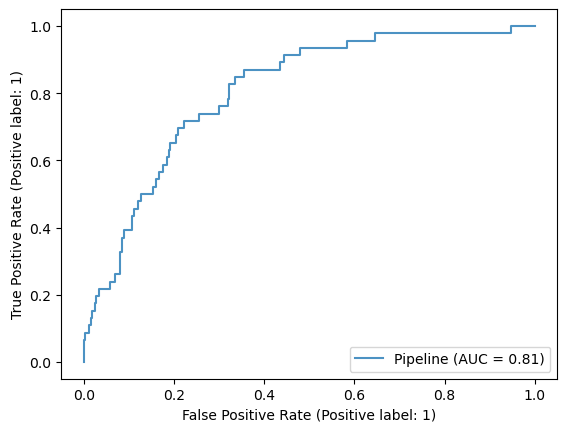

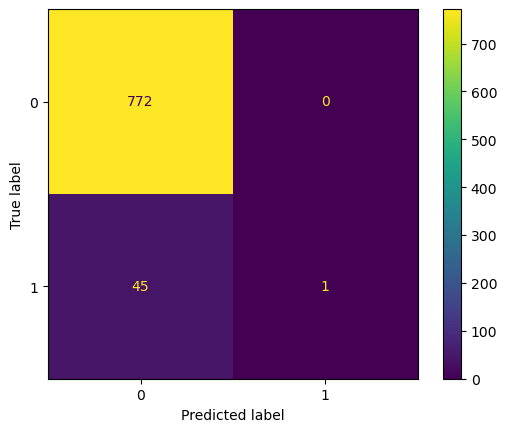

In [34]:
chosenModel =  grid.best_estimator_

chosenModel.fit(X_train,y_train) 
predict = chosenModel.predict(X_valid) 
prob = chosenModel.predict_proba(X_valid)[:, 1]
                            
print ('Accuracy: ' + str(accuracy_score(y_valid,predict)))

acc = roc_auc_score(y_valid, prob) # compute accuracy 
print("ROC score on test examples = %4.4f" %acc) 

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(chosenModel, X_valid, y_valid, ax=ax, alpha=0.8)

ConfusionMatrixDisplay.from_estimator(chosenModel, X_valid, y_valid)

We see that we are obtaining an accuracy of 94% and a AUC of 80%. The second value is realtively low, according to the mean and standard deviation obtained with the repeated cross validation, and for a different random split of the data we could expect higher scores.

In any case, the most relevant data for us at this point is the confussion matrix. We see that __our model is labeling almost all the points as *no Stroke*. As we have an unbalanced dataset, this gives us a really high accuracy, but our model is unable to identify the Strokes__ (more technically, it has a etremely low recall). This is is extremely problematic, as in this case it is extremely important to corretcly identify the person that might have an stroke, even if it reduces the overall accuracy of the model.

A solution for this problem could be lowering the treshold for labelling a instace as stroke (for instance, labelling as *Stroke* all the points with a probability of stroke higher than 0.2). Still, this is a partial solution that does not solve the underlying problem: we need to find a model with a higher recall.

### Objective score: F1

To solve the problem explained above, we need to find a new model. To do so, we change the __target score to F1__, which gives a __greater importance to recall__ and its more fitting to the objectives of our challenge (finding the people that might have an stroke) and the unbalanced of our dataset. 

__The key idea here is that for us saying to someone that they might have a Stroke when their probability is not that high is less problematic than not correctly identifying the people with a high probability of having strokes, because this second mistake could cost them their lives.__

In the model, this involves two changes in our code: deleting the *eval_metric = 'auc'* from the XGBoost model and choosing *scoring='f1'* in our Grid.

In the result, we will see that the parameter __*scale_pos_weight* gets a higher importance__. We have established several values to this parameter taking into account the documentation.

In [39]:
from math import sqrt
print(3888/199)
print(sqrt(3888/199))

19.537688442211056
4.420145748978314


In [38]:
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 40
nrepeats = 3
params = {'classifier__n_estimators': [50,100,200,400,1000,4000],
        'classifier__scale_pos_weight': [1,2,4.7,10,19.537, 50,100],
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__max_depth': [2,3,4,6,8]
        }



my_pipeline = Pipeline(steps=[('classifier', XGBClassifier(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=1))
                             ])

cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=nrepeats, random_state=15) 

grid = RandomizedSearchCV(estimator=my_pipeline, param_distributions=params, n_iter=param_comb, scoring='f1', 
                          n_jobs=4, cv=cv, verbose=3, random_state=1001 )

# execute the grid search 
grid_result = grid.fit(X_new, y) 
# report the best configuration 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[23:44:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Best: 0.267132 using {'classifier__subsample': 0.6, 'classifier__scale_pos_weight': 10, 'classifier__n_estimators': 400, 'classifier__min_child_weight': 1, 'classifier__max_depth': 3, 'classifier__gamma': 2, 'classifier__colsample_bytree': 0.6}


In [40]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__subsample,param_classifier__scale_pos_weight,param_classifier__n_estimators,param_classifier__min_child_weight,param_classifier__max_depth,param_classifier__gamma,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
6,0.842972,0.062887,0.011835,0.006411,0.6,10,400,1,3,2,...,0.242424,0.281481,0.280255,0.250000,0.291667,0.236025,0.269231,0.267132,0.036921,1
17,0.115645,0.015121,0.010456,0.007971,1.0,10,50,5,3,5,...,0.253659,0.297143,0.263158,0.285714,0.228571,0.234043,0.292453,0.259383,0.031621,2
0,1.821754,0.050490,0.016106,0.004598,0.6,10,1000,1,2,2,...,0.267516,0.283688,0.257669,0.236111,0.258993,0.231707,0.276316,0.254955,0.033433,3
33,1.720616,0.328752,0.020091,0.006974,0.6,50,400,5,6,1.5,...,0.240385,0.279330,0.247525,0.237288,0.251429,0.226804,0.246154,0.252660,0.023522,4
12,0.428525,0.120439,0.009391,0.006245,0.6,19.537,100,5,4,2,...,0.249027,0.263374,0.250000,0.267782,0.229075,0.233463,0.258065,0.249311,0.014763,5


We can see that with __the best model using the new score has a *scale_pos_weight':* of 10__ (that is, it is given 10 times more importance to the instances with a value of 1 for 'Stroke'). Moreover, __we see on the table that all the models with a high score are given a *scale_pos_weight* higher than 1, the value chosen before.__

As we before, we will explain what this means with an __example__, using the division of the data done before.

[23:44:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 0.8459657701711492
ROC score on test examples = 0.7950


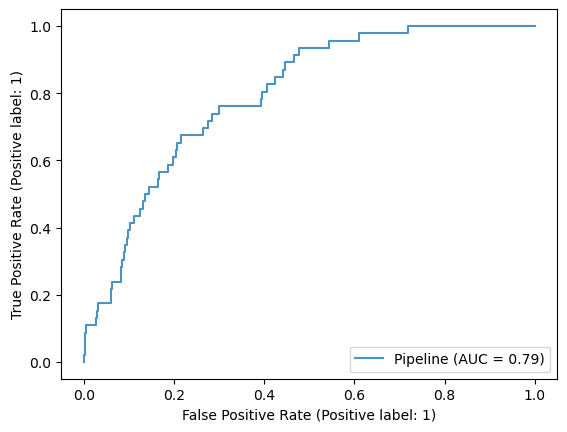

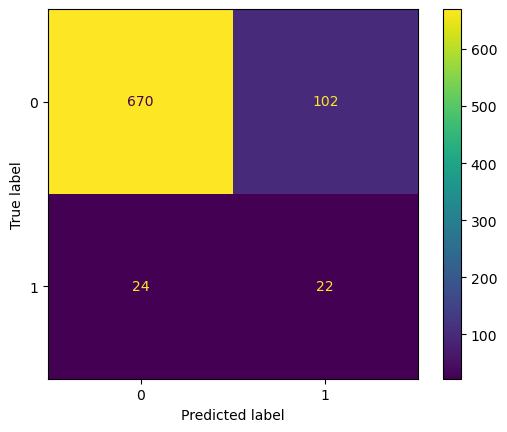

In [41]:
chosenModel2 =  grid.best_estimator_

chosenModel2.fit(X_train,y_train) 
predict = chosenModel2.predict(X_valid) 
prob = chosenModel2.predict_proba(X_valid)[:, 1]
                            
print ('Accuracy: ' + str(accuracy_score(y_valid,predict)))

acc = roc_auc_score(y_valid, prob) # compute accuracy 
print("ROC score on test examples = %4.4f" %acc) 

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(chosenModel2, X_valid, y_valid, ax=ax, alpha=0.8)

ConfusionMatrixDisplay.from_estimator(chosenModel2, X_valid, y_valid)

As we can see, in this case the accuracy as decreased considerably (from 94% to 84%), and the AUC has also decreased. This is due to the fact that now we have many more false positives. Before we didn't have this problem, because the model was classifying virtually every point as *Stroke=0*. __Before we had a recall of almost 0, and now we have raised to almost a 50%.__

(Take into account that this is just an illustrative example. With a other division of the data the scores would be different, and the right approach to obtain the real values would be doing repeated cross validation over the data).

__Furthermore, now it will make sense to increase the recall by reducing the probability treshold, as we have a model oriented towards correctly identifying the 'Strokes'.__

__Taking into account the importance of correctly identifying the people who might have a stroke, as it could potentially save their live, this model is prefered to the one before.__

## Submission

In this section we fit the chosen models to the whole of the training data, charge the test_set, preprocess it following the same steps as before and calculate the probabilities for the submission.

In [ ]:
#chosenModel.fit(X_new,y)
#chosenModel2.fit(X_new,y)

In [ ]:
test_set = pd.read_csv('C:/Users/santi/OneDrive/Escritorio/SD Hackathon/testing-stroke.csv')

In [ ]:
test_set.head()

In [ ]:
id = test_set['id']
test_set = test_set.drop('id', axis=1)

In [ ]:
X_new.columns

In [ ]:
len(test_set)

In [ ]:
test_set.columns

In [ ]:
X_sub=[]

imp = SimpleImputer(strategy='median')
test_set['BodyMassIndex'] = imp.fit_transform(test_set['BodyMassIndex'].values.reshape(-1, 1) )

one_hot_encoder = OneHotEncoder(sparse=False, drop = "first")

# apply the one hot encoder logic 
encoder_vars_array = one_hot_encoder.fit_transform(test_set[categorical_vars])

# create object for the feature names using the categorical variables
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create a dataframe to hold the one hot encoded variables
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)

# concatenate the new dataframe back to the original input variables dataframe
X_sub = pd.concat([test_set.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)

# drop the original input 2 and input 3 as it is not needed anymore
X_sub.drop(categorical_vars, axis = 1, inplace = True)

In [ ]:
prob_sub = chosenModel.predict_proba(X_sub)[:, 1]
prob_sub

In [ ]:
len(prob_sub)
len(X_sub)

In [ ]:
d = {'id': id, 'Stroke': prob_sub}
df = pd.DataFrame(data=d)

In [ ]:
df.to_csv('C:/Users/santi/OneDrive/Escritorio/SD Hackathon/sub_model1.csv', index=False)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
chosenModel =  grid.best_estimator_


my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer(strategy="mean", fill_value='missing')),
                              ('classifier', grid.best_estimator_)
                             ])

my_pipeline.fit(X_train,y_train) 
predict = chosenModel.predict(X_valid) 
prob = chosenModel.predict_proba(X_valid)[:, 1]
                            
print (accuracy_score(y_valid,predict))

acc = roc_auc_score(y_valid, prob) # compute accuracy 
print("ROC score on test examples = %4.4f" %acc) 
print(confusion_matrix(y_valid, predict))

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(chosenModel, X_valid, y_valid, ax=ax, alpha=0.8)